## Imports

In [1]:
import pandas as pd
import numpy as np
import shap 

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint


from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\SexyEmy\Documents\Emy documents\Thesis\gaiamachine\notebooks\emy_workspace\tests\random_forest\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading data 

In [2]:
# Load data
df = pd.read_csv('dataset_full.csv')

## Dataset analysis

In [3]:
# Knowing the count per class
print(f"Count class 0 'substellar' : {len(df[df.binary==0])}")
print(f"Count class 1 'binary' : {len(df[df.binary==1])}")

Count class 0 'substellar' : 39
Count class 1 'binary' : 45


### Stratified K-fold CV

In [4]:
X = df.drop(columns=['source_id', 'nss_solution_type', 'binary'])
y = df['binary']

In [5]:
model = BalancedRandomForestClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [6]:
param_grid = {
    'n_estimators': [30, 50, 100],
    'max_features': [None, 'sqrt', 'log2', 0.5],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4], 
    'criterion': ['gini', 'entropy'] 
}

In [7]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [8]:
scores = cross_val_score(grid_search, X, y, cv=cv, scoring='accuracy')

print(f'Accuracy scores per fold: {scores}')
print(f'Average accuracy: {np.mean(scores)}')
print(f'Standard deviation of accuracy: {np.std(scores)}')

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Accuracy scores per fold: [0.82352941 0.70588235 0.76470588 0.76470588 0.8125    ]
Average accuracy: 0.7742647058823529
Standard deviation of accuracy: 0.04182783133331731


In [ ]:
y_pred_cv = cross_val_predict(grid_search, X, y, cv=cv)
y_pred_cv

In [10]:
best_params = grid_search.fit(X, y).best_params_
print("Best parameters found by GridSearchCV:")
print(best_params)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best parameters found by GridSearchCV:
{'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 30}


In [ ]:
model = BalancedRandomForestClassifier(**best_params, random_state=45)
model.fit(X, y)


BalancedRandomForestClassifier(min_samples_leaf=4, n_estimators=30,
                               random_state=45)

In [ ]:
#Predict on unseen data
df_unseen = pd.read_csv('dataset_unseen.csv')
df_unseen = df_unseen.drop(columns=['source_id', 'nss_solution_type'])

predictions = model.predict(df_unseen)
print(predictions)

#### Confusion matrix

In [ ]:
cm = confusion_matrix(y, y_pred_cv, normalize='true')
ConfusionMatrixDisplay(confusion_matrix = cm).plot();

In [ ]:
print(classification_report(y, y_pred_cv))

#### Feature importance

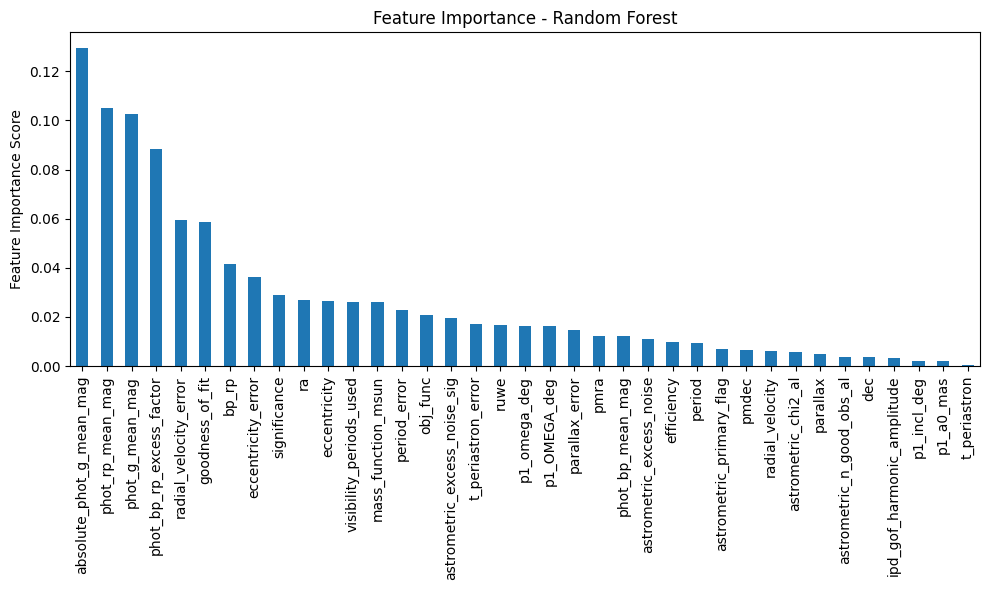

In [ ]:

feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
feature_importances.plot.bar(ax=ax);
ax.set_title("Feature Importance - Random Forest")
ax.set_ylabel('Feature Importance Score')
plt.tight_layout()
plt.show()

#### SHAP feauture importance

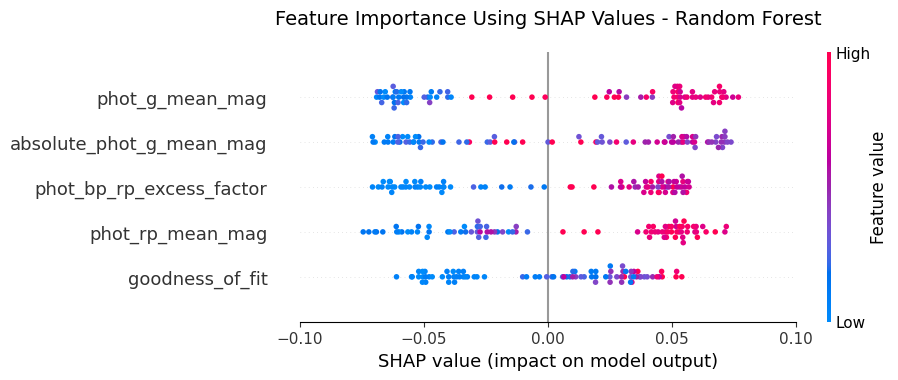

In [ ]:
explainer = shap.TreeExplainer(model)
explanation = explainer(X)

shap_df = pd.DataFrame(explanation[:, :, 1].values, columns=X.columns)
top_5_features = shap_df.abs().mean().nlargest(5).index.tolist()

shap_values_subset = explanation[:, top_5_features, 1]
explanation_subset = shap.Explanation(
    values=shap_values_subset.values,
    base_values=explanation.base_values,
    data=X[top_5_features].values,
    feature_names=top_5_features,
)

shap.plots.beeswarm(explanation_subset, show=False)
x_min, x_max = -0.1, 0.1
plt.xticks(np.linspace(x_min, x_max, 5))
plt.title("Feature Importance Using SHAP Values - Random Forest", fontsize=14, pad=20)
plt.show()